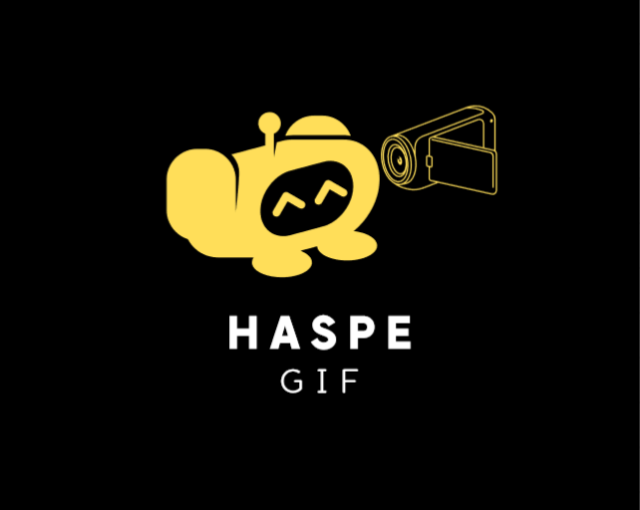

# **Installing and Importing Libraries**

In [1]:
!pip install python-telegram-bot
!pip install nest_asyncio
!pip install pandas
!pip install numpy
!pip install scikit-learn
!pip install tensorflow
!pip install transformers
!pip install google-cloud-videointelligence
!pip install moviepy
!pip install --upgrade ffmpeg
!pip install joblib

In [2]:
import nest_asyncio
nest_asyncio.apply()

from typing import Final
import telegram
from telegram import Update
from telegram.ext import Application, CommandHandler, MessageHandler, filters, ContextTypes

import os
import io
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from transformers import BertTokenizer, TFBertForSequenceClassification
from google.cloud import videointelligence_v1p3beta1 as videointelligence
from google.cloud.videointelligence_v1p3beta1.types import Feature, VideoContext, TextDetectionConfig
from google.colab import files
import torch
import moviepy.editor as mp
import time
import joblib

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Importing the Saved Model and Definining Functions**

In [4]:
TOKEN: Final = 'Telegram Bot API Token'

# Load the BERT model and tokenizer
model_directory = '/Hate Speech Hinglish Language/hate_speech_model'
loaded_model = TFBertForSequenceClassification.from_pretrained(model_directory)
loaded_tokenizer = BertTokenizer.from_pretrained(model_directory)

# Load the TensorFlow model
tf_model_filename = '/Hate Speech Hinglish Language/tf_model.h5'

# Load the label encoder
label_encoder_filename = '/Hate Speech Hinglish Language/label_encoder.pkl'
loaded_label_encoder = joblib.load(label_encoder_filename)

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at /content/drive/MyDrive/Hate Speech Detection Project/Project Execution/Backend Development/Hate Speech Detection Models/Mark 12/Saved Model/Hate Speech Hinglish Language/hate_speech_model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


In [5]:
def predict_hate_speech(text, model, tokenizer, label_encoder, device):
    encoding = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=128,
        padding='max_length',
        truncation=True,
        return_tensors='tf'
    )

    input_ids = encoding['input_ids']
    attention_mask = encoding['attention_mask']

    # Make prediction
    with tf.device('/cpu:0'):  # Ensure predictions are made on CPU
        outputs = model.predict([input_ids, attention_mask])
        logits = outputs.logits

    # Convert logits to probabilities and get the predicted label
    probabilities = tf.nn.softmax(logits, axis=1).numpy()[0]
    predicted_label_id = np.argmax(probabilities)
    predicted_label = label_encoder.classes_[predicted_label_id]

    return predicted_label

# Device specification (remove any explicit device specification)
torch_device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

hateful_emojis = [u'😠', u'😡', u'🤬', u'🥵', u'🤢', u'🤮', u'👿', u'💩', u'👎', u'👎🏻', u'👎🏼', u'👎🏽', u'👎🏾', u'👎🏿', u'🖕', u'🖕🏻', u'🖕🏼', u'🖕🏽', u'🖕🏾', u'🖕🏿', u'👙', u'🩱', u'💦', u'🍌', u'🍑', u'🥊', u'🏴‍☠️']

def has_hateful_emoji(text):
    for emoji in hateful_emojis:
        if emoji in text:
            return True
    return False

def predict_hate_speech_text(text):
    # Check for hateful emojis
    if has_hateful_emoji(text):
        return "Hate"  # If hateful emoji is detected, classify as Hate

    prediction = predict_hate_speech(text, loaded_model, loaded_tokenizer, loaded_label_encoder, torch_device)
    return "Hate" if prediction == "yes" else "Non-Hate"

# Function to detect text from a GIF using Google Cloud Video Intelligence API
def detect_text_from_gif(gif_content):
    os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = r"/Text Detection/credentials.json"

    client = videointelligence.VideoIntelligenceServiceClient()

    # Convert the GIF content to a bytes-like object
    gif_bytes = io.BytesIO(gif_content)

    features = [Feature.TEXT_DETECTION]

    operation = client.annotate_video(
        request={
            "input_content": gif_bytes.read(),
            "features": features,
        }
    )

    result = operation.result(timeout=90)

    for annotation in result.annotation_results:
        for text_segment in annotation.text_annotations:
            detected_text = text_segment.text.strip()

    return detected_text

# Function to classify hate speech in the extracted text from a GIF
def predict_hate_speech_gif(gif_content):
    # Extract text from GIF using Google Cloud Video Intelligence API
    gif_text = detect_text_from_gif(gif_content)

    # Use the Hate Speech Detection model for prediction
    return predict_hate_speech_text(gif_text)


# **Code for Bot 4 - Haspe GIF**

In [6]:
# Commands and message handling for the Haspe GIF Bot
async def start_command(update: Update, context: ContextTypes.DEFAULT_TYPE):
    await update.message.reply_text('Hello! Thanks for chatting with me! I am the Haspe GIF Bot.')

async def help_command(update: Update, context: ContextTypes.DEFAULT_TYPE):
    await update.message.reply_text('I am the Haspe GIF Bot! Please send a GIF so I can predict if it contains hate speech.')

async def gif_command(update: Update, context: ContextTypes.DEFAULT_TYPE):
    await update.message.reply_text('Please send the GIF!')

async def handle_gif(update: Update, context: ContextTypes.DEFAULT_TYPE):
    if update.message.animation:
        await update.message.reply_text('Processing your GIF. Please wait...')
        # Get the GIF file from the message
        gif_file = update.message.animation
        # Get the corresponding File object
        file = await context.bot.get_file(gif_file.file_id)
        # Download the file content as bytearray
        gif_content_bytearray = await file.download_as_bytearray()
        # Convert the bytearray to bytes
        gif_content_bytes = bytes(gif_content_bytearray)
        # Extract text from the GIF
        extracted_text = detect_text_from_gif(gif_content_bytes)
        # Predict hate speech from the extracted text
        predicted_label = predict_hate_speech_gif(gif_content_bytes)
        # Send the prediction back to the user
        response_message = f'Extracted Text from GIF: {extracted_text}\nHate Speech Prediction for GIF: {predicted_label}'
        await update.message.reply_text(response_message)
    else:
        await update.message.reply_text('The given input is not in gif format. Please enter gif as Input.')

def error(update: Update, context: ContextTypes.DEFAULT_TYPE):
    print(f'Update {update} caused error {context.error}')

In [ ]:
if __name__ == '__main__':
    app = Application.builder().token(TOKEN).build()

    app.add_handler(CommandHandler('start', start_command))
    app.add_handler(CommandHandler('help', help_command))
    app.add_handler(CommandHandler('gif', gif_command))

    # Handle incoming GIFs
    app.add_handler(MessageHandler(None, handle_gif))

    # Errors
    app.add_error_handler(error)

    # Polls the Bot
    print('Polling...')
    app.run_polling(poll_interval=3)

Polling...
